#### Classification the fruits is rotten or fresh 

In [126]:
# import libaraies 
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter


In [158]:
SEED = 42
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
DATA_DIR = "/kaggle/input/fresh-vs-rotten-fruit-images"
print(os.listdir(DATA_DIR))


['README.dataset.txt', 'Fruit Freshness Dataset']


In [159]:
# secod after improving 
DATA_DIR = "/kaggle/input/fresh-vs-rotten-fruit-images/Fruit Freshness Dataset/Fruit Freshness Dataset"
print("Folders:", os.listdir(DATA_DIR))


Folders: ['Apple', 'Strawberry', 'Banana']


In [160]:
# colloact all image path 
all_images = glob.glob(DATA_DIR + "/**/*.jpg", recursive=True)
print("Total images:", len(all_images))
print("Sample image:", all_images[0])


Total images: 519
Sample image: /kaggle/input/fresh-vs-rotten-fruit-images/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (44).jpg


# Load the dataset 

In [161]:
import tensorflow as tf

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [162]:
import glob
import numpy as np

all_images = glob.glob(DATA_DIR + "/**/*.jpg", recursive=True)

print("Total images:", len(all_images))
print("Sample path:", all_images[0])


Total images: 519
Sample path: /kaggle/input/fresh-vs-rotten-fruit-images/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (44).jpg


# create a  label for the images

In [198]:
labels = []
for path in all_images:
    fruit = path.split("/")[-3]
    quality = path.split("/")[-2]
    labels.append(f"{fruit}_{quality}")

labels = np.array(labels)

unique_classes = sorted(set(labels))
class_to_idx = {c:i for i,c in enumerate(unique_classes)}

y = np.array([class_to_idx[l] for l in labels])

print("CLASS MAP:")
for i, c in enumerate(unique_classes):
    print(i, c)


CLASS MAP:
0 Apple_Fresh
1 Apple_Rotten
2 Banana_Fresh
3 Banana_Rotten
4 Strawberry_Fresh
5 Strawberry_Rotten


In [164]:
# encode the label to number 
class_to_idx = {name:i for i, name in enumerate(unique_classes)}
y = np.array([class_to_idx[l] for l in labels])

print("Example label:", labels[0], "->", y[0])


Example label: Apple_Fresh -> 0


In [199]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [200]:
# oversample only trainingset 
from collections import defaultdict
import random
import numpy as np

def oversample(X, y):
    class_to_items = defaultdict(list)
    for xi, yi in zip(X, y):
        class_to_items[int(yi)].append(xi)

    max_count = max(len(v) for v in class_to_items.values())

    X_new, y_new = [], []
    for cls, items in class_to_items.items():
        extra = random.choices(items, k=max_count - len(items))
        items_balanced = items + extra
        X_new.extend(items_balanced)
        y_new.extend([cls] * len(items_balanced))

    return np.array(X_new), np.array(y_new)

X_train_bal, y_train_bal = oversample(X_train, y_train)


In [193]:
from collections import Counter

print("Train:", Counter(y_train))
print("Val :", Counter(y_val))
print("Test:", Counter(y_test))


Train: Counter({4: 167, 0: 87, 3: 72, 1: 41, 5: 35, 2: 13})
Val : Counter({4: 21, 0: 11, 3: 9, 1: 5, 5: 5, 2: 1})
Test: Counter({4: 21, 0: 11, 3: 9, 1: 5, 5: 4, 2: 2})


In [167]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i:w for i,w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 0.7950191570881227, 1: 1.6869918699186992, 2: 5.32051282051282, 3: 0.9606481481481481, 4: 0.41417165668662675, 5: 1.9761904761904763}


# Create Datapipeline tf.datapiple

In [201]:
import tensorflow as tf

IMG_SIZE = (128,128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train_bal, y_train_bal))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE).shuffle(3000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [202]:
# check the validation labels 
for imgs, labs in val_ds.take(1):
    print("Val labels:", labs.numpy()[:20])
    print("Val label names:", [unique_classes[i] for i in labs.numpy()[:20]])


Val labels: [3 3 0 0 0 4 3 3 4 4 4 1 4 0 3 4 3 1 1 4]
Val label names: ['Banana_Rotten', 'Banana_Rotten', 'Apple_Fresh', 'Apple_Fresh', 'Apple_Fresh', 'Strawberry_Fresh', 'Banana_Rotten', 'Banana_Rotten', 'Strawberry_Fresh', 'Strawberry_Fresh', 'Strawberry_Fresh', 'Apple_Rotten', 'Strawberry_Fresh', 'Apple_Fresh', 'Banana_Rotten', 'Strawberry_Fresh', 'Banana_Rotten', 'Apple_Rotten', 'Apple_Rotten', 'Strawberry_Fresh']


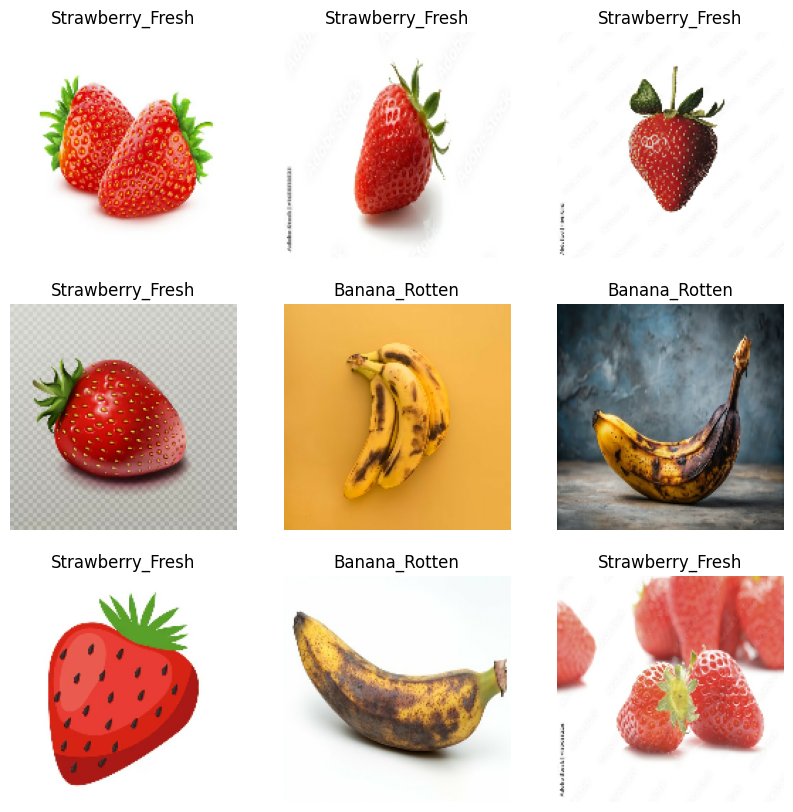

In [169]:
# show the images the data 
plt.figure(figsize=(10, 10))
for images, labels_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(unique_classes[labels_batch[i].numpy()])
        plt.axis("off")
plt.show()


DATA AUGUMENTION FOR MORE IMAGES 

In [170]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Model Defined 

In [95]:

from tensorflow.keras.regularizers import l2

num_classes = len(unique_classes)

model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,

    # Block 1
    layers.Conv2D(32, 3, padding="same", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding="same", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Block 4 (extra)
    layers.Conv2D(256, 3, padding="same", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.35),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             

 Total params: 424,518 (1.62 MB)

 Trainable params: 423,302 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [96]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# callbacks

# Early stopping callbacks monitor validation metrics and halt training when performance stops improving, saving time and computational resources.

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    ),
]


# train the model 

In [98]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks_list
)


Epoch 1/40


E0000 00:00:1768240326.522221      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3476 - loss: 1.9774
Epoch 1: val_accuracy improved from -inf to 0.09615, saving model to best_scratch_cnn.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.3577 - loss: 1.9513 - val_accuracy: 0.0962 - val_loss: 1.8443 - learning_rate: 3.0000e-04
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6856 - loss: 1.0253
Epoch 2: val_accuracy did not improve from 0.09615
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6872 - loss: 1.0223 - val_accuracy: 0.0962 - val_loss: 1.8095 - learning_rate: 3.0000e-04
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8004 - loss: 0.7434
Epoch 3: val_accuracy did not improve from 0.09615
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8000 - loss: 0.7426 - val_accuracy: 0.0962 - val_loss: 1.8305 - learning_rate: 3.0000e-04
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8312 - loss: 0.6006
Epoch 4: val_accuracy did not improve from 

# Evulate on the test dataset****

In [99]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0954 - loss: 1.8167
Test Accuracy: 0.09615384787321091


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
                   precision    recall  f1-score   support

      Apple_Fresh       0.00      0.00      0.00        11
     Apple_Rotten       0.10      1.00      0.19         5
     Banana_Fresh       0.00      0.00      0.00         2
    Banana_Rotten       0.00      0.00      0.00         9
 Strawberry_Fresh       0.00      0.00      0.00        21
Strawberry_Rotten       0.00      0.00      0.00         4

         accuracy                           0.10        52
        macro avg       0.02      0.17      0.03        52
     weighted avg       0.01      0.10      0.02        52



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


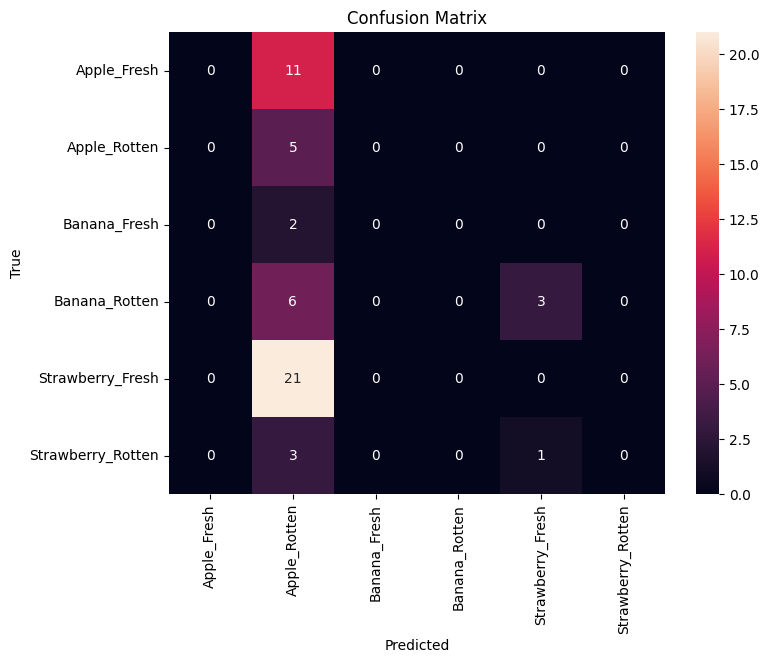

In [100]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=unique_classes))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


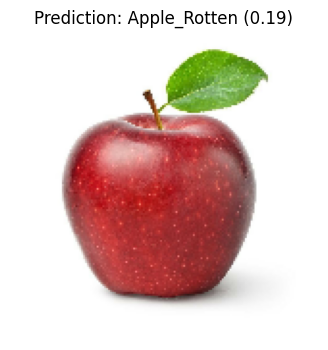

In [108]:
def predict_single_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img_show = tf.cast(img, tf.uint8)

    img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    idx = np.argmax(pred)

    plt.figure(figsize=(4,4))
    plt.imshow(img_show.numpy())
    plt.axis("off")
    plt.title(f"Prediction: {unique_classes[idx]} ({pred[idx]:.2f})")
    plt.show()

# test
predict_single_image(all_images[50])


# my model is show overfitting because its giving wrong prediction atleast not classify image 
so i want to reduce the model where define the add check the labels and use dropout for prevent the overfitting 

In [115]:
num_classes = len(unique_classes)

model_best = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,

    layers.Conv2D(16, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_best.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [116]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i:w for i,w in enumerate(class_weights)}
print(class_weight_dict)


{0: 0.7950191570881227, 1: 1.6869918699186992, 2: 5.32051282051282, 3: 0.9606481481481481, 4: 0.41417165668662675, 5: 1.9761904761904763}


In [117]:
history = model_best.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list,
    class_weight=class_weight_dict
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1907 - loss: 1.7964
Epoch 1: val_loss improved from 1.82779 to 1.73934, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.1950 - loss: 1.7835 - val_accuracy: 0.4038 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4324 - loss: 1.2658
Epoch 2: val_loss improved from 1.73934 to 1.67625, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4373 - loss: 1.2676 - val_accuracy: 0.4038 - val_loss: 1.6763 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5529 - loss: 1.1050
Epoch 3: val_loss did not improve from 1.67625
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5557 - loss: 1.1074 - val_accuracy: 0.3846 - val_loss: 1.7177 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6145 - loss: 1.0909
Epoch 4: val_loss did n

In [118]:
test_loss, test_acc = model_best.evaluate(test_ds)
print("Test Accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3734 - loss: 1.7070
Test Accuracy: 0.4038461446762085


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


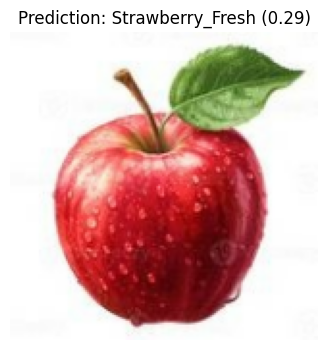

In [122]:
def predict_single_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img_show = tf.cast(img, tf.uint8)

    img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    pred = model_best.predict(img)[0]
    idx = np.argmax(pred)

    plt.figure(figsize=(4,4))
    plt.imshow(img_show.numpy())
    plt.axis("off")
    plt.title(f"Prediction: {unique_classes[idx]} ({pred[idx]:.2f})")
    plt.show()

# test
predict_single_image(all_images[40])


In [123]:
best_model = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = best_model.evaluate(test_ds)
print("✅ Test Loss:", test_loss)
print("✅ Test Accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3734 - loss: 1.7070 
✅ Test Loss: 1.6689027547836304
✅ Test Accuracy: 0.4038461446762085


In [124]:
import numpy as np

preds = np.argmax(best_model.predict(val_ds), axis=1)
print("Predicted label counts:", np.bincount(preds))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted label counts: [ 0  0  5  0 47]


In [ ]:
# after alots of improving its doing wrong predction so i have do next improve the model again 

# after alots of improving its doing wrong predction so i have do next improve the model again 

# DEFINE THE MODEL

In [207]:
num_classes = len(unique_classes)

model_best3 = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,

    layers.Conv2D(16, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),


    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_best3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_best3.summary()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_53" is incompatible with the layer: expected shape=(None, 160, 160, 3), found shape=(None, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=False, name=keras_tensor_958>',)
  • kwargs={'mask': 'None'}

# callback improvent after getting wrong prediction 

In [185]:
callbacks_list1 = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )
]


In [208]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# train the model 

In [209]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list,
    class_weight=class_weight_dict
)


Epoch 1/50


E0000 00:00:1768245590.146257      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7778 - loss: 0.9212
Epoch 1: val_loss did not improve from 1.64342
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7775 - loss: 0.9204 - val_accuracy: 0.0385 - val_loss: 2.8411 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8424 - loss: 0.6397
Epoch 2: val_loss did not improve from 1.64342
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8423 - loss: 0.6387 - val_accuracy: 0.0192 - val_loss: 3.5471 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8229 - loss: 0.6400
Epoch 3: val_loss did not improve from 1.64342

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8228 - loss: 0.6401 - val_accuracy: 0.0769 - val_loss: 3.0934 - learning_rate: 0.0010
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8487 - loss: 0.5602
Epoch 4: val_loss did not improve

# load the model and evulate the best model on the test data with the help of callable

In [210]:
best_model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8918 - loss: 0.4049
Test Loss: 0.39746394753456116
Test Accuracy: 0.8846153616905212


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
                   precision    recall  f1-score   support

      Apple_Fresh       1.00      0.64      0.78        11
     Apple_Rotten       0.62      1.00      0.77         5
     Banana_Fresh       1.00      1.00      1.00         2
    Banana_Rotten       1.00      0.89      0.94         9
 Strawberry_Fresh       0.91      0.95      0.93        21
Strawberry_Rotten       0.80      1.00      0.89         4

         accuracy                           0.88        52
        macro avg       0.89      0.91      0.88        52
     weighted avg       0.91      0.88      0.88        52



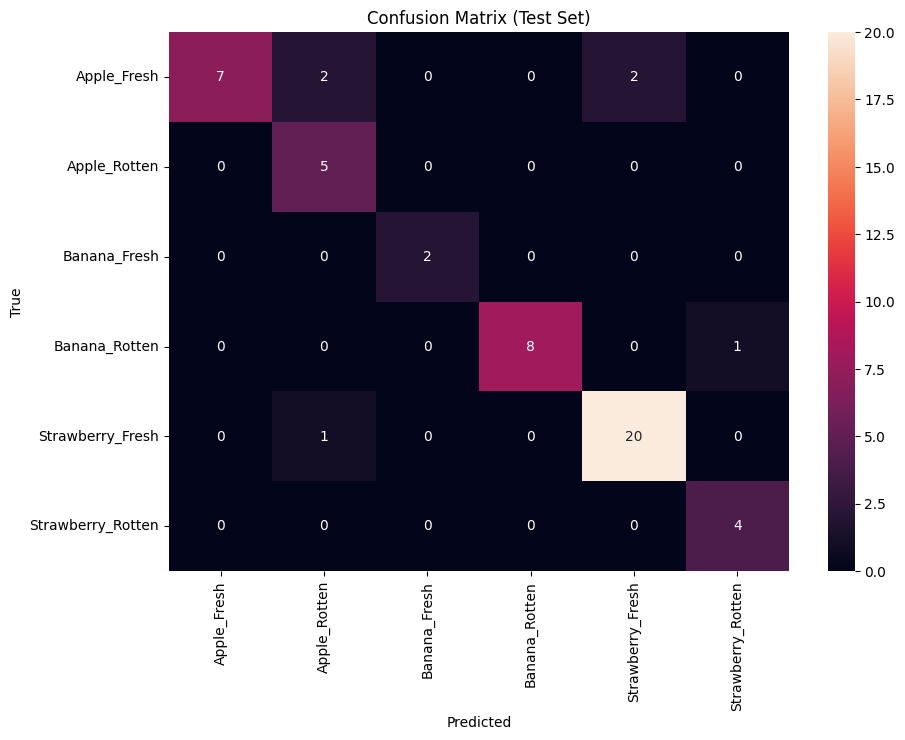

In [211]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=unique_classes))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


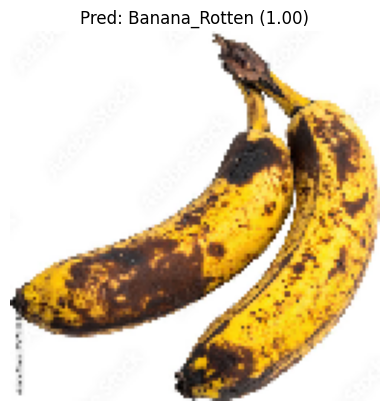

In [214]:
def predict_single_image(img_path):
    img = keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = keras.utils.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    probs = model.predict(x)[0]
    idx = np.argmax(probs)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {unique_classes[idx]} ({probs[idx]:.2f})")
    plt.show()

# test on any image
predict_single_image(X_test[11])


# why still getting again and again wronng prediction because data is imbalance so do balance using oversampling and only change the traindataset and apply same artecheture cnn then get 
1.testaccuracy=88
2.trainaccuracy=90
3.validationaccuracy=87

In [215]:
# save the model 
model.save("fruit_freshness_cnn_model.h5")


# Model Load For Inference Part #

In [222]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



model_inf = tf.keras.models.load_model("/kaggle/working/fruit_freshness_cnn_model.h5")
print("Model loaded ✅")


print("Model loaded successfully ✅")


Model loaded ✅
Model loaded successfully ✅


In [223]:
def inference_on_10_images(model, dataset, class_names, n=10):
    images_list = []
    labels_list = []

    # collect images until we have n
    for images, labels in dataset:
        for img, lab in zip(images, labels):
            images_list.append(img.numpy())
            labels_list.append(int(lab.numpy()))
            if len(images_list) == n:
                break
        if len(images_list) == n:
            break

    X = np.array(images_list)
    y_true = np.array(labels_list)

    preds = model_inf.predict(X)
    y_pred = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1)

    # show results
    plt.figure(figsize=(15, 10))
    for i in range(n):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(X[i])
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]

        title = f"T: {true_label}\nP: {pred_label}\nConf: {confidences[i]:.2f}"
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.show()

    # accuracy on these n images
    acc = np.mean(y_true == y_pred)
    print(f"✅ Accuracy on {n} test images: {acc*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


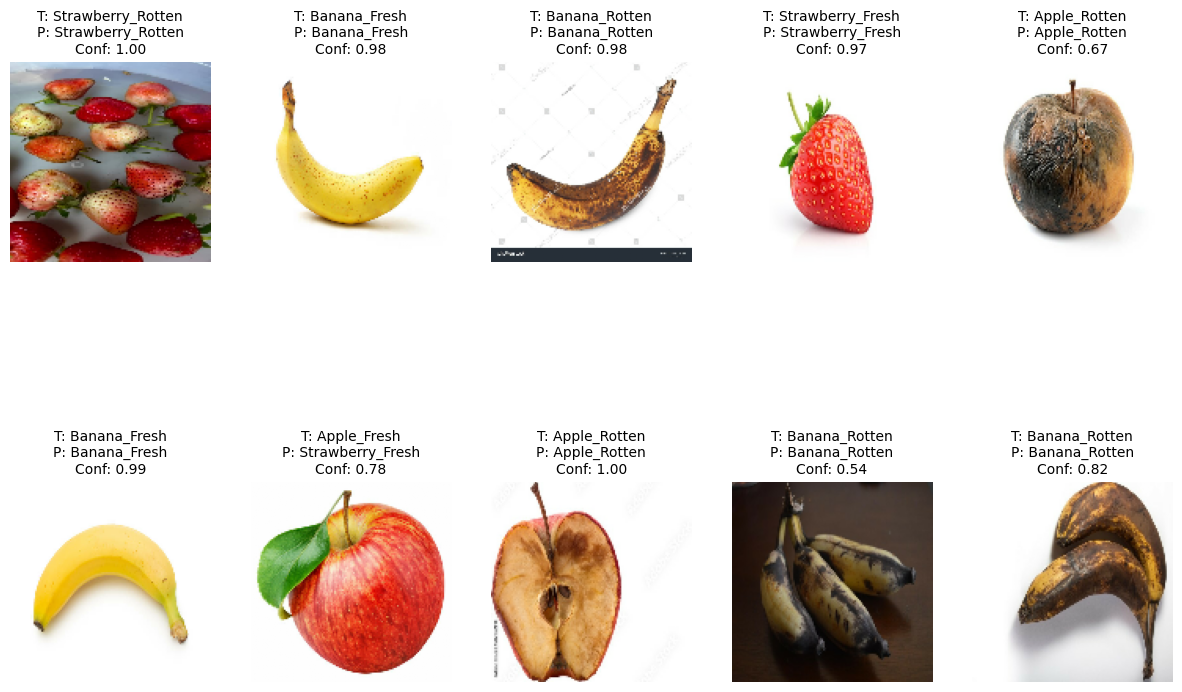

✅ Accuracy on 10 test images: 90.00%


In [224]:
inference_on_10_images(best_model, test_ds, unique_classes, n=10)
